In [1]:
import warnings
from importlib import reload

import explore as ex
import model as m
import wrangle as w

warnings.simplefilter('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext pycodestyle_magic

# Screaming into your Zillow
### predicting tax_value of housing from previous predictions

# Goals
- Determine driving factors of tax value of houses sold in 2016
- Use those factors to build a model to predict housing places
- Use that model to attempt to predict the tax value of houses

# Data Dictionary
Variable Name | `zillow` Database Equivalent | Definition
---|---|---
**bed_count** | bedroomcnt | No. of bedrooms in property
**calc_sqft**|calculatedfinishedsquarefeet | The calculated finished square footage of property
**fips** | fips | FIPS code of property 
**fips_6037**| N/A | Dummy value where `fips == 6037` (used in modeling)
**fips_6059**| N/A | Dummy value where `fips == 6059` (used in modeling)
**fips_6111**| N/A | Dummy value where `fips == 6111` (used in modeling)
**full_baths** | fullbathroomcnt | No. of full bathrooms on property
**half_baths** | N/A | No. of half bathrooms on property 
**tax_value** | taxvaluedollarcnt | Tax value of the property

# Acquire
* Data acquired from CodeUp Database
* Did initial exploratory analysis within SQL.
* Identified columns with minimal null values which showed promise for modeling.
* Before cleaning, data had 52442 rows and 8 columns (See Data Dictionary for columns selected)
* Each row represents a property which had a prediction run by Zillow's model
* Each column represents a feature of that property

# Prepare
### Preparation actions:
- dropped null values in `calc_sqft, tax_value` and `year_built`
- removed homes with 0 bedrooms or bathrooms. That's not a house, that's a shed.
- filled `NaN` values (~in `full_baths` with rounded-down `bath_count` (most houses only have one half bath).
- engineered `half_baths` column as `bath_count - full_baths`
- changed data types to from floating point to integer as appropriate
- Removed Outliers, including houses with more than 8 bathrooms, 7 bathrooms, 7 half baths, or which had a valuation over $3,500,000. These values were chosen to limit data loss
- I then scaled the data using a RobustScaler to improve model performance
- final data contains 51,612 rows and 

In [2]:
reload(w)
zillow_df = w.wrangle_zillow(from_csv=True)
train, validate, test = w.tvt_split(zillow_df)
train.head()

x = ['bed_count', 'full_baths', 'half_baths',
     'calc_sqft', 'year_built', 'fips_6037','fips_6059','fips_6111']
y = ['tax_value']
scaled_train, validate, test = w.scale_data(train, validate, test, x)

# Explore
## A look at the data:

In [3]:
train.head()

,tax_value,bed_count,full_baths,calc_sqft,year_built,fips,half_baths,fips_6037,fips_6059,fips_6111
31429,530000.0,3,2,1252.0,1957,6059,0,0,1,0
15311,678000.0,4,3,1880.0,1986,6037,0,1,0,0
21007,262051.0,3,1,1256.0,1941,6037,0,1,0,0
3576,516436.0,3,2,1363.0,1969,6037,0,1,0,0
17938,992784.0,3,2,1587.0,1951,6037,0,1,0,0


In [4]:
train.describe()

,tax_value,bed_count,full_baths,calc_sqft,year_built,fips,half_baths,fips_6037,fips_6059,fips_6111
count,2.879800e+04,28798.000000,28798.000000,28798.000000,28798.000000,28798.000000,28798.000000,28798.000000,28798.000000,28798.000000
mean,4.872434e+05,3.298354,2.217376,1893.878360,1963.420099,6049.221265,0.129835,0.643934,0.271686,0.084381
std,4.586083e+05,0.901676,0.938192,907.811107,23.004123,21.076562,0.340847,0.478843,0.444836,0.277963
min,2.501100e+04,1.000000,1.000000,152.000000,1878.000000,6037.000000,0.000000,0.000000,0.000000,0.000000
25%,1.956140e+05,3.000000,2.000000,1268.000000,1950.000000,6037.000000,0.000000,0.000000,0.000000,0.000000
50%,3.727910e+05,3.000000,2.000000,1651.000000,1961.000000,6037.000000,0.000000,1.000000,0.000000,0.000000
75%,6.102658e+05,4.000000,3.000000,2288.750000,1979.000000,6059.000000,0.000000,1.000000,1.000000,0.000000
max,3.499594e+06,6.000000,10.000000,10605.000000,2016.000000,6111.000000,3.000000,1.000000,1.000000,1.000000


## Is there a linear correlation between calculated square feet and tax value?

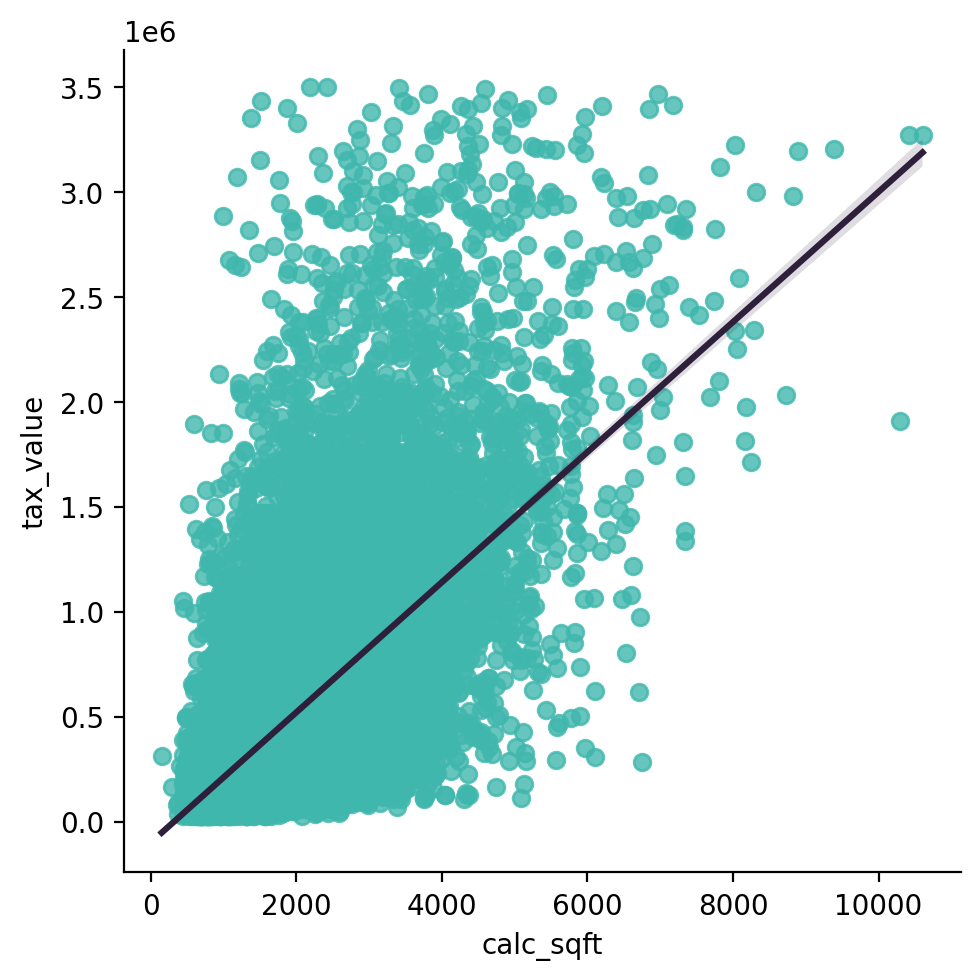

In [5]:
reload(ex)
ex.plot_1(train)

## Is there a linear correlation between tax_value and calc_sqft?
$H_0$: There is no linear correlations between tax_value and calc_sqft

$H_a$ There is a linear correlation between tax_value and calc_sqft

In [6]:
ex.tax_sqft_test(train)

## r = 0.5155482264067529

## Because $\alpha$ > p,we  reject $H_0$

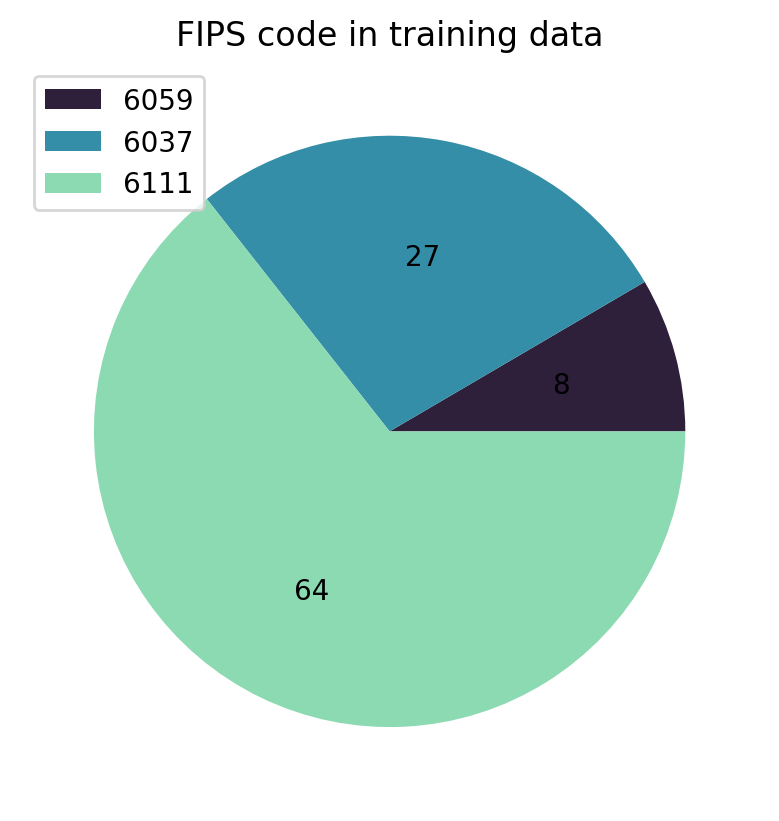

In [7]:
reload(ex)
ex.obligatory_pie_chart(train)

## Question does FIPS Code affect Tax Value?



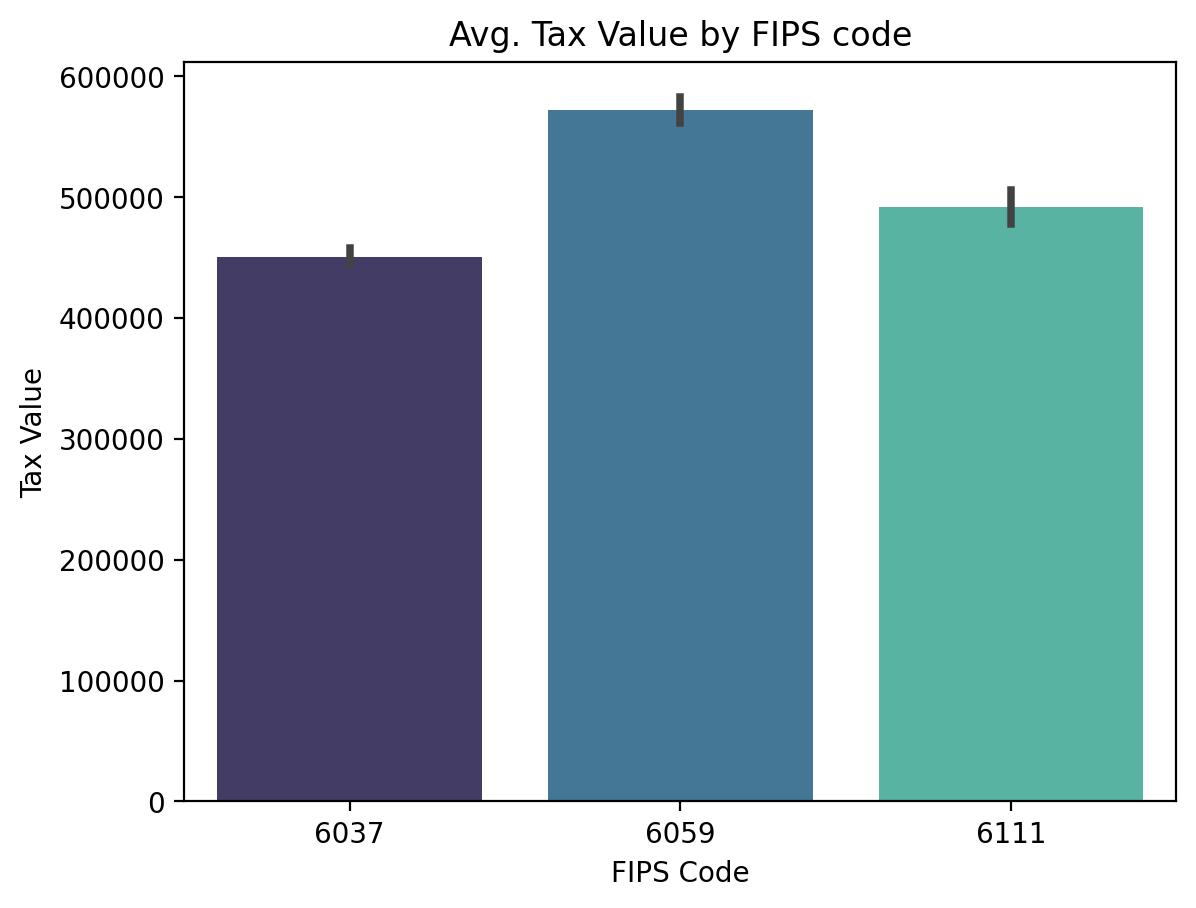

In [8]:
reload(ex)
ex.fips_graph(train)

$H_0$: $\mu_{6037}= \mu_{6059} = \mu_{6111}$


$H_0$: $\mu_{6037} \neq \mu_{6059} \neq \mu_{6111}$

### Assumptions:
- Independent Samples: Yes
- Normal Distribution: No, however there is a large enough sample size that Central Limit Theorem kicks in.
- Equal Variance: Let's find out!

$H_0$: $\sigma^{2}_{6037} = \sigma^{2}_{6059} = \sigma^{2}_{6111}$

$H_a$: $\sigma^{2}_{6037} \neq \sigma^{2}_{6059} \neq \sigma^{2}_{6111}$

In [9]:
reload(ex)
ex.levene_test(train)

## t = 46.2570997390986 

 ## p = 8.770002954068133e-21 

## Because t > 0 and $\alpha$ > p,we  reject $H_0$

### Because we reject the null hypothesis, we must use the non-parametric test (Kruskal-Wallace)


In [10]:
ex.fips_v_tax(train)

## t = 972.3968130825687 

 ## p = 7.026109744234875e-212 

## Because t > 0 and $\alpha$ > p,we  reject $H_0$

## Question: does the number of bedrooms affect the tax value?

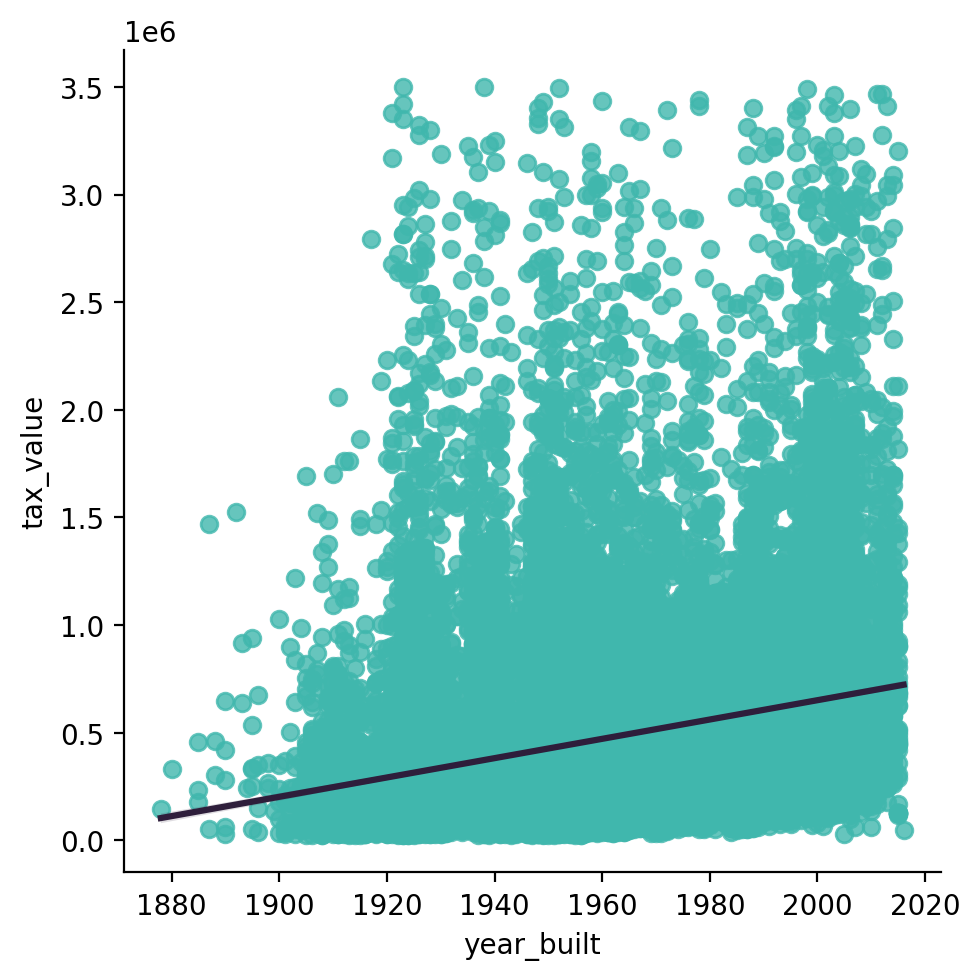

In [11]:
reload(ex)
ex.year_v_tax_value(train)

## Takeaways
- Calculated Square Feet appears to be the best single predictor of Tax Value
- Bedroom count and fips are also predictors of Tax Value, but to a lesser extent
- Year built does not appear to be a good metric

# Modeling
- For modeling, I selected 3 model types
    - Linear Regression
    - LASSO-LARS
    - Generalized Linear Model (GLM)

In [12]:

xtrain = scaled_train[x]
ytrain = scaled_train[y]
xvalid = validate[x]
yvalid = validate[y]

In [13]:
m.select_baseline(train.tax_value)

|                 |         SSE |         MSE |   RMSE |
|:----------------|------------:|------------:|-------:|
| Mean Baseline   | 6.05663e+15 | 2.10314e+11 | 458600 |
| Median Baseline | 6.43386e+15 | 2.23414e+11 | 472666 |
### Because mean outperformed median on all metrics,         we will use mean as our baseline

In [14]:
model_eval, winner = m.evaluate_models(xtrain,ytrain,xvalid,yvalid)
model_eval

| Methodology                      |   Train RMSE |   Validate RMSE |
|:---------------------|-------------:|----------------:|
| Baseline             |       458600 |          447043 |
| Linear Regression    |       351816 |          349121 |
| LASSO LARS           |       351820 |          349096 |
| General Linear Model |       408194 |          399019 |

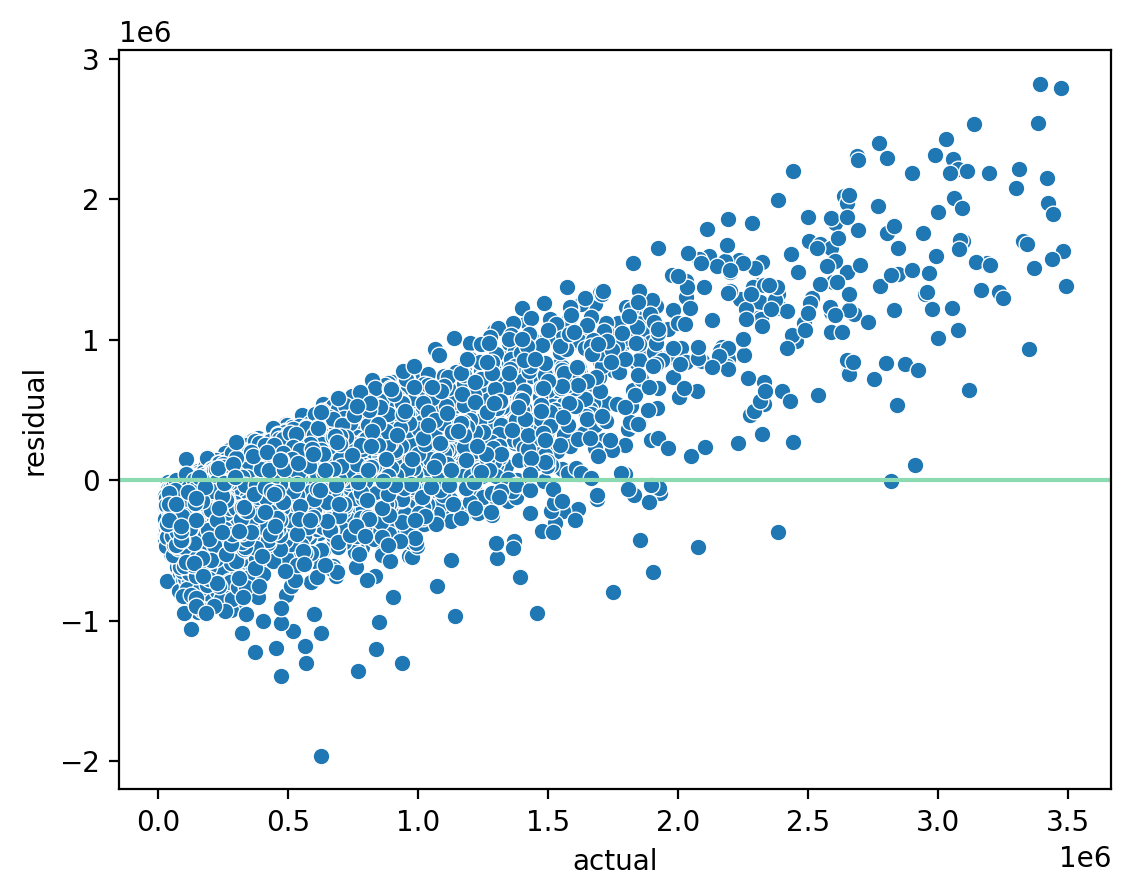

### Mean Squared Error: 347818.6

In [15]:
reload(m)
m.run_test(winner,test[x],test[y])

# Conclusions
## Exploration
- Calculated Square Feet is the most significant predictor of Tax Value vs previous predictions
- Bedroom Count and FIPS code were also predictors, but to a lesser degree.
- Number of full baths was not a good predictor of Tax Value
## Modeling
- The final model of LASSO + LARS performed the best
- The final model also outperformed the baseline both in and out of sample.

## Next Steps
- broaden predictions tested on to include 2016 data
- Additional data verification.
- Use a classifier model to separate by valu`e
- Formal removal of outliers.